In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
sns.set_theme(style='whitegrid')

# Data Preprocessing & Feature Engineering

In [2]:
def cleaning(df):
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
  # df['Customer ID'] = df['Customer ID'].astype('int64')
  df.rename(columns = {"Customer ID": "CustomerID"}, inplace = True)

  df.loc[df.Description.isnull()==False, "lowercase_descriptions"] = df.loc[df.Description.isnull()==False,"Description"].apply(lambda l: l.lower())
  df.loc[df.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = df.loc[df.lowercase_descriptions.isnull()==False, "lowercase_descriptions"].apply(lambda l: np.where("nan" in l, None, l))
  df = df.loc[(df.CustomerID.isnull()==False) & (df.lowercase_descriptions.isnull()==False)].copy()

  df["IsCancelled"]=np.where(df.Invoice.apply(lambda l: l[0]=="C"), True, False)
  df = df.loc[df.IsCancelled==False].copy()
  df = df.drop("IsCancelled", axis=1)

  def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

  df["StockCodeLength"] = df.StockCode.apply(lambda l: len(l))
  df["nNumericStockCode"] = df.StockCode.apply(lambda l: count_numeric_chars(l))
  df = df.loc[(df.nNumericStockCode == 5) | (df.StockCodeLength==6)].copy()
  df = df.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

  def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

  df["UpCharsInDescription"] = df.Description.apply(lambda l: count_upper_chars(l))
  df = df.loc[df.UpCharsInDescription > 5].copy()
  df = df.drop(["lowercase_descriptions", "UpCharsInDescription"], axis=1)

  df = df.loc[(df.Price > np.round(np.exp(-2),1)) & (df.Price < np.round(np.exp(3),1))].copy()
  df = df.loc[df.Quantity < np.round(np.exp(4))].copy()

  df['TotalValue'] = df.Quantity * df.Price
  df['year'] = pd.DatetimeIndex(df.InvoiceDate).year
  df['month'] = pd.DatetimeIndex(df.InvoiceDate).month
  df['day'] = pd.DatetimeIndex(df.InvoiceDate).day
  df['hour'] = pd.DatetimeIndex(df.InvoiceDate).hour
  df['year_month'] = df.year.astype('string') +'-'+ df.month.astype('string')
  return df


In [3]:
gdp2010 = ({'United Kingdom': 39689, 'France': 40638, 'USA': 48467, 'Belgium': 44142, 'Australia': 52088,
           'EIRE': 48608, 'Germany': 41532, 'Portugal': 22499, 'Japan': 44968, 'Denmark': 58041, 'Nigeria': 2280,
           'Netherlands': 50950, 'Poland': 12613, 'Spain': 30503, 'Channel Islands': 0, 'Italy': 36001, 'Cyprus': 31024,
           'Greece': 26691, 'Norway': 87694, 'Austria': 46858, 'Sweden': 52869, 'United Arab Emirates': 33893,
           'Finland': 46460, 'Switzerland': 77117, 'Unspecified': 0, 'Malta': 21799, 'Bahrain': 20722, 'RSA': 8149,
           'Bermuda': 101875, 'Hong Kong': 32550, 'Singapore': 47237, 'Thailand': 5076, 'Israel': 30780, 'Lithuania': 11988,
           'West Indies': 0, 'Lebanon': 7762, 'Korea': 23087, 'Brazil': 11286, 'Canada': 47562, 'Iceland': 43237,
           'Saudi Arabia': 19263, 'Czech Republic': 19960, 'European Community': 32943})

gdp2011 = ({'United Kingdom': 42285, 'France': 43791, 'USA': 49883, 'Belgium': 47349, 'Australia': 62574,
           'EIRE': 52109, 'Germany': 46645, 'Portugal': 23187, 'Japan': 48760, 'Denmark': 61754, 'Nigeria': 2488,
           'Netherlands': 54159, 'Poland': 13880, 'Spain': 31636, 'Channel Islands': 0, 'Italy': 38599, 'Cyprus': 32396,
           'Greece': 25451, 'Norway': 100601, 'Austria': 51375, 'Sweden': 60756, 'United Arab Emirates': 39195,
           'Finland': 51082, 'Switzerland': 91254, 'Unspecified': 0, 'Malta': 23156, 'Bahrain': 22514, 'RSA': 8811,
           'Bermuda': 97774, 'Hong Kong': 35142, 'Singapore': 53890, 'Thailand': 5492, 'Israel': 33776, 'Lithuania': 14377,
           'West Indies': 0, 'Lebanon': 7675, 'Korea': 25096, 'Brazil': 13245, 'Canada': 52224, 'Iceland': 47715,
           'Saudi Arabia': 23746, 'Czech Republic': 21871, 'European Community': 35716})

In [4]:
def get_features(input):
    df = input.copy(deep=True)
    total_invoice = df.groupby(['CustomerID']).Invoice.nunique()
    avg_invoice = total_invoice / df.groupby(['CustomerID']).year_month.nunique()
    n_invoice_month = df.groupby(['CustomerID', 'year_month']).Invoice.nunique().reset_index()
    min_invoice =  n_invoice_month.groupby(['CustomerID']).Invoice.min()
    max_invoice = n_invoice_month.groupby(['CustomerID']).Invoice.max()
    a = df.groupby(['CustomerID', 'year_month']).Invoice.nunique()
    std_invoice = a.groupby(['CustomerID']).std()

    money_by_month = df.groupby(['CustomerID', 'year_month']).TotalValue.sum().reset_index()
    avg_money = money_by_month.groupby(['CustomerID']).TotalValue.sum() / money_by_month.groupby(['CustomerID']).year_month.nunique()
    min_money = money_by_month.groupby(['CustomerID']).TotalValue.min()
    max_money = money_by_month.groupby(['CustomerID']).TotalValue.max()
    b = df.groupby(['CustomerID', 'year_month']).TotalValue.sum()
    std_money = b.groupby(['CustomerID']).std()
    total_product = df.groupby(['CustomerID']).StockCode.nunique()
    avg_product = total_product / df.groupby(['CustomerID']).year_month.nunique()

    end_date = df['InvoiceDate'].max()
    snapshot_date = end_date + datetime.timedelta(days=1)

    recency = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days}).InvoiceDate
    frequency = df.groupby(['CustomerID']).agg({'Invoice': 'count'}).Invoice
    monetary = df.groupby(['CustomerID']).TotalValue.sum()

    mode_hour = df.groupby(['CustomerID']).hour.value_counts().unstack().idxmax(axis=1)
    avg_product_month = df.groupby(['CustomerID']).StockCode.nunique() / df.groupby(['CustomerID']).year_month.nunique()
    max_product = df.groupby(['CustomerID']).StockCode.value_counts().unstack().idxmax(axis=1)

    avg_sale = df.groupby(['CustomerID', 'Invoice']).TotalValue.sum().reset_index().groupby(['CustomerID']).TotalValue.mean()

    gdp = df.groupby(['CustomerID']).Country.value_counts().unstack().idxmax(axis=1)
    if df.year.iloc[0] == 2010:
        gdp.replace(gdp2010, inplace=True)
    elif df.year.iloc[0] == 2011:
        gdp.replace(gdp2011, inplace=True)



    features = pd.DataFrame({'total_invoice':total_invoice, 'avg_invoice':avg_invoice, 'min_invoice':min_invoice,
                             'max_invoice':max_invoice, 'std_invoice':std_invoice, 'avg_money':avg_money, 'min_money':min_money,
                             'max_money':max_money, 'std_money':std_money, 'total_product':total_product, 'avg_product':avg_product,
                             'recency':recency, 'frequency':frequency, 'monetary_value':monetary, 'mode_hour':mode_hour,
                             'avg_product_month':avg_product_month, 'avg_sale':avg_sale, 'gdp': gdp
                             })
    return features

In [5]:
def feature_scaling(dataframe):
    df = dataframe.copy(deep=True)
    for col in df.columns:
        df[col] = df[col].apply(lambda x: np.log(x+0.001))
    df = df.fillna(0)
    normalized_df = MinMaxScaler().fit_transform(df)
    return normalized_df

In [6]:
data = pd.read_csv('data/online_retail_II.csv')

In [7]:
data = cleaning(data)

In [8]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalValue,year,month,day,hour,year_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,2009,12,1,7,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,1,7,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,1,7,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,2009,12,1,7,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009,12,1,7,2009-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067365,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011,12,9,12,2011-12
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011,12,9,12,2011-12
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,9,12,2011-12
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,9,12,2011-12


In [9]:
train_df = data[data.year == 2010]
test_df = data[data.year == 2011]

In [10]:
x_train = get_features(train_df)
x_test = get_features(test_df)

In [11]:
x_train.index = x_train.index.astype('int').astype('string') + '_2010'
x_test.index = x_test.index.astype('int').astype('string') + '_2011'

In [12]:
x_train['year'] = pd.Series([2010 for x in range(x_train.shape[0])], index=x_train.index)
x_test['year'] = pd.Series([2011 for x in range(x_test.shape[0])], index=x_test.index)

In [13]:
x_test

,total_invoice,avg_invoice,min_invoice,max_invoice,std_invoice,avg_money,min_money,max_money,std_money,total_product,avg_product,recency,frequency,monetary_value,mode_hour,avg_product_month,avg_sale,gdp,year
CustomerID,,,,,,,,,,,,,,,,,,,
12347_2011,6,1.00,1,1,0.000000,554.801667,224.82,1274.52,372.035229,85,14.166667,2,149,3328.81,12,14.166667,554.801667,47715,2011
12348_2011,2,1.00,1,1,0.000000,18.700000,17.00,20.40,2.404163,2,1.000000,249,2,37.40,10,1.000000,18.700000,51082,2011
12349_2011,1,1.00,1,1,NaN,1417.600000,1417.60,1417.60,NaN,71,71.000000,19,71,1417.60,9,71.000000,1417.600000,38599,2011
12350_2011,1,1.00,1,1,NaN,294.400000,294.40,294.40,NaN,16,16.000000,310,16,294.40,16,16.000000,294.400000,100601,2011
12352_2011,7,1.75,1,3,0.957427,346.435000,231.73,512.50,120.042154,57,14.250000,36,77,1385.74,14,14.250000,197.962857,100601,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280_2011,1,1.00,1,1,NaN,180.600000,180.60,180.60,NaN,10,10.000000,278,10,180.60,9,10.000000,180.600000,42285,2011
18281_2011,1,1.00,1,1,NaN,80.820000,80.82,80.82,NaN,7,7.000000,181,7,80.82,10,7.000000,80.820000,42285,2011
18282_2011,2,1.00,1,1,0.000000,89.025000,77.84,100.21,15.817979,12,6.000000,8,12,178.05,13,6.000000,89.025000,42285,2011


In [14]:
x = pd.concat([x_train, x_test])

In [15]:
features = pd.DataFrame(feature_scaling(x))

In [16]:
features_train = features[features.iloc[:,18] == 0]
feature_test = features[features.iloc[:,18] == 1]

In [17]:
features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.132845,0.000000,0.0,0.000000,0.000000,0.449428,0.364096,0.469290,0.709393,0.426675,0.581642,0.884224,0.356100,0.413646,0.589650,0.581642,0.456701,0.949525,0.0
1,0.132845,0.000000,0.0,0.000000,0.000000,0.728778,0.692317,0.708437,0.831868,0.570429,0.727419,0.482872,0.518272,0.632782,0.660242,0.727419,0.740572,0.954172,0.0
2,0.132845,0.000000,0.0,0.000000,0.000000,0.541510,0.553272,0.515073,0.666270,0.395303,0.549828,0.331611,0.360675,0.485880,0.660242,0.549828,0.550273,0.958073,0.0
3,0.132845,0.000000,0.0,0.000000,0.000000,0.731302,0.736298,0.686511,0.751047,0.601161,0.758585,0.689129,0.514926,0.634762,0.127189,0.758585,0.743137,0.944232,0.0
4,0.000000,0.000000,0.0,0.000000,0.726591,0.591896,0.617680,0.547056,0.433334,0.408743,0.657852,0.548620,0.341134,0.464312,0.725962,0.657852,0.601475,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,0.000000,0.000000,0.0,0.000000,0.726591,0.534527,0.563936,0.494033,0.433334,0.309110,0.556813,0.959279,0.257981,0.419309,0.239379,0.556813,0.543178,0.952963,1.0
8261,0.000000,0.000000,0.0,0.000000,0.726591,0.444186,0.479302,0.410536,0.433334,0.261215,0.508243,0.886119,0.218008,0.348441,0.339737,0.508243,0.451374,0.952963,1.0
8262,0.132845,0.000000,0.0,0.000000,0.000000,0.455050,0.475348,0.432867,0.606550,0.333593,0.487252,0.354373,0.278414,0.418056,0.589650,0.487252,0.462414,0.952963,1.0
8263,0.531585,0.156816,0.0,0.368474,0.723071,0.550879,0.501157,0.627276,0.755122,0.747680,0.687981,0.236221,0.742485,0.635083,0.660242,0.687981,0.506132,0.952963,1.0


In [18]:
features_train = features_train.iloc[:, :-1]
feature_test = feature_test.iloc[:, :-1]

In [19]:
feature_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
4130,0.343488,0.000000,0.0,0.000000,0.000000,0.660628,0.586989,0.696951,0.804642,0.596503,0.604246,0.118089,0.560748,0.676152,0.513406,0.604246,0.671319,0.959520
4131,0.132845,0.000000,0.0,0.000000,0.000000,0.279733,0.315208,0.267577,0.488389,0.093021,0.243344,0.940497,0.077634,0.280527,0.339737,0.243344,0.284260,0.963220
4132,0.000000,0.000000,0.0,0.000000,0.726591,0.766031,0.780814,0.708000,0.433334,0.572334,0.823750,0.501834,0.477665,0.600913,0.239379,0.823750,0.778428,0.948014
4133,0.000000,0.000000,0.0,0.000000,0.726591,0.589431,0.615371,0.544778,0.433334,0.372225,0.620819,0.977854,0.310656,0.462378,0.787439,0.620819,0.598970,1.000000
4134,0.373049,0.186721,0.0,0.291990,0.722124,0.607717,0.590175,0.602346,0.733684,0.542839,0.605044,0.610786,0.486758,0.598909,0.660242,0.605044,0.553658,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,0.000000,0.000000,0.0,0.000000,0.726591,0.534527,0.563936,0.494033,0.433334,0.309110,0.556813,0.959279,0.257981,0.419309,0.239379,0.556813,0.543178,0.952963
8261,0.000000,0.000000,0.0,0.000000,0.726591,0.444186,0.479302,0.410536,0.433334,0.261215,0.508243,0.886119,0.218008,0.348441,0.339737,0.508243,0.451374,0.952963
8262,0.132845,0.000000,0.0,0.000000,0.000000,0.455050,0.475348,0.432867,0.606550,0.333593,0.487252,0.354373,0.278414,0.418056,0.589650,0.487252,0.462414,0.952963
8263,0.531585,0.156816,0.0,0.368474,0.723071,0.550879,0.501157,0.627276,0.755122,0.747680,0.687981,0.236221,0.742485,0.635083,0.660242,0.687981,0.506132,0.952963


# K-Means & Gaussian Mixture Model

In [20]:
kmean_score_df = pd.DataFrame(columns=['n_clusters', 'distortion', 'inertia', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])
for i in range(2,11):
    model = KMeans(n_clusters=i, random_state=0).fit(features_train)

    distortion = sum(np.min(cdist(features_train, model.cluster_centers_, 'euclidean'), axis=1)) / features_train.shape[0]
    inertia = model.inertia_
    silhouette = silhouette_score(features_train, model.labels_)
    calinski_harabasz = calinski_harabasz_score(features_train, model.labels_)
    davies_bouldin = davies_bouldin_score(features_train, model.labels_)

    to_append = pd.DataFrame([[i, distortion, inertia, silhouette, calinski_harabasz, davies_bouldin]],
                             columns=['n_clusters', 'distortion', 'inertia', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])
    kmean_score_df = pd.concat([kmean_score_df,to_append])

Text(0.5, 1.0, 'silhouette_score')

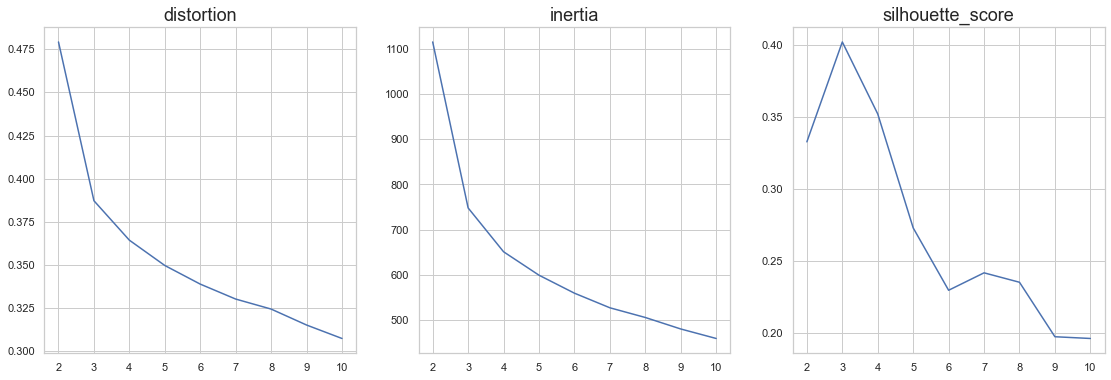

In [21]:
fig, ax = plt.subplots(1,3, figsize=(19,6))
ax[0].plot(kmean_score_df.n_clusters, kmean_score_df.distortion)
ax[1].plot(kmean_score_df.n_clusters, kmean_score_df.inertia)
ax[2].plot(kmean_score_df.n_clusters, kmean_score_df.silhouette_score)
ax[0].set_title('distortion', fontsize=18)
ax[1].set_title('inertia', fontsize=18)
ax[2].set_title('silhouette_score', fontsize=18)

In [22]:
kmean_model = KMeans(n_clusters=3, random_state=0).fit(features_train)
label_kmean = kmean_model.labels_

In [23]:
pd.Series(label_kmean).value_counts()

0    1561
1    1393
2    1176
dtype: int64

/Users/minhkhoa/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


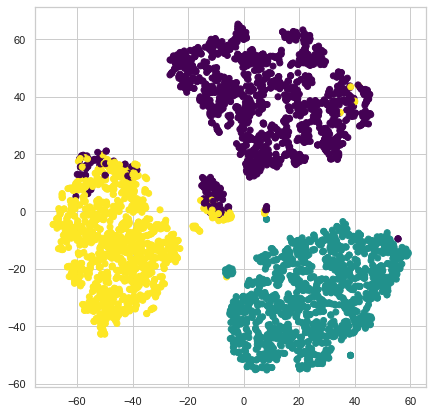

In [24]:
x_plot = TSNE(n_components=2, learning_rate='auto', random_state=20).fit_transform(features_train)
plt.figure(figsize=(7,7))
plt.scatter(x_plot[:,0], x_plot[:,1],c=label_kmean, cmap='viridis')

In [25]:
gmm_score_df = pd.DataFrame(columns=['n_clusters', 'BIC', 'AIC', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])
for i in range(2,11):
    gm = GaussianMixture(n_components=i, random_state=123)
    gm.fit(features_train)
    labels = gm.predict(features_train)
    bic = gm.bic(features_train)
    aic = gm.aic(features_train)

    silhouette = silhouette_score(features_train, labels)
    calinski_harabasz = calinski_harabasz_score(features_train, labels)
    davies_bouldin = davies_bouldin_score(features_train, labels)

    to_append = pd.DataFrame([[i, bic, aic, silhouette, calinski_harabasz, davies_bouldin]],
                             columns=['n_clusters', 'BIC', 'AIC', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])
    gmm_score_df = pd.concat([gmm_score_df,to_append])

Text(0.5, 1.0, 'silhouette_score')

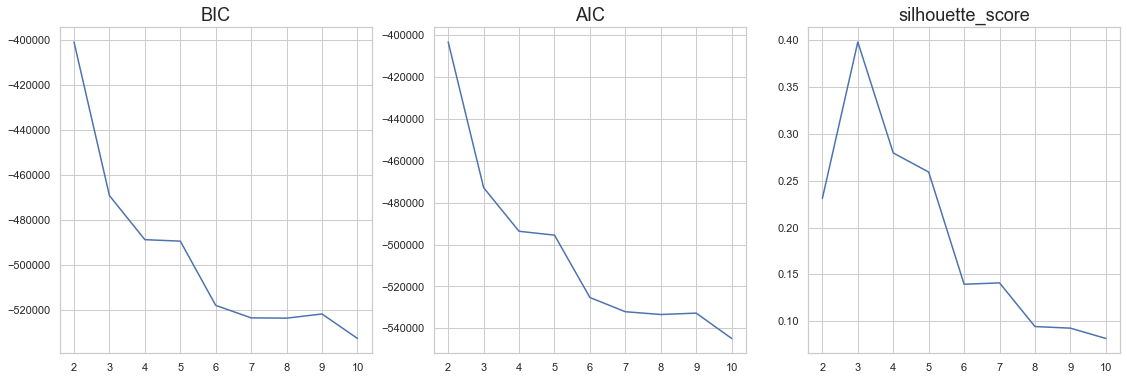

In [26]:
fig, ax = plt.subplots(1,3, figsize=(19,6))
ax[0].plot(gmm_score_df.n_clusters, gmm_score_df.BIC)
ax[1].plot(gmm_score_df.n_clusters, gmm_score_df.AIC)
ax[2].plot(gmm_score_df.n_clusters, gmm_score_df.silhouette_score)
ax[0].set_title('BIC', fontsize=18)
ax[1].set_title('AIC', fontsize=18)
ax[2].set_title('silhouette_score', fontsize=18)

In [27]:
gmm_model = GaussianMixture(n_components=3, random_state=123, n_init=10)
label_gmm = gmm_model.fit_predict(features_train)

In [28]:
pd.Series(label_gmm).value_counts()

2    1540
1    1397
0    1193
dtype: int64

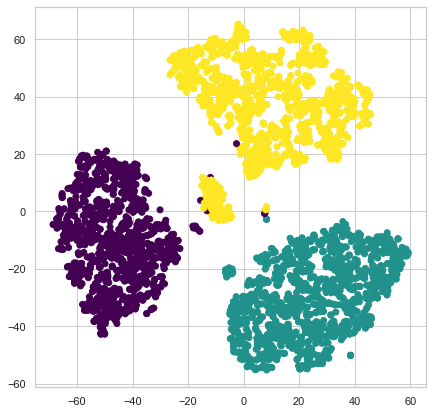

In [29]:
plt.figure(figsize=(7,7))
plt.scatter(x_plot[:,0], x_plot[:,1],c=label_gmm, cmap='viridis')

# Feature Selection

Text(0, 0.5, 'Mean decrease in impurity')

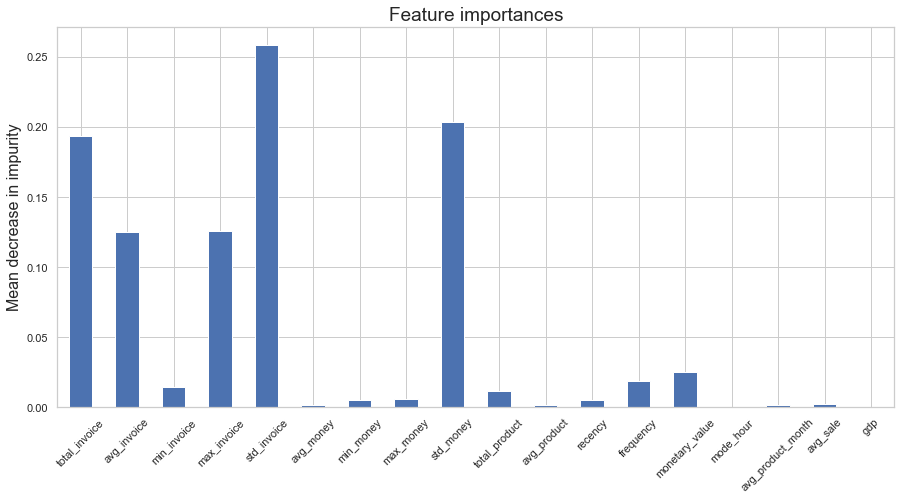

In [30]:
y_train2 = pd.Series(label_gmm).copy(deep=True)

clf = RandomForestClassifier(min_samples_leaf=2, random_state=21).fit(features_train, y_train2)
importances = clf.feature_importances_
feature_names = x_train.columns[:-1]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15, 7))
forest_importances.plot.bar(ax=ax, rot=45)
ax.set_title("Feature importances", fontsize=19)
ax.set_ylabel("Mean decrease in impurity", fontsize=16)

In [31]:
x2 = x[['total_invoice', 'avg_invoice', 'min_invoice', 'max_invoice', 'std_invoice', 'std_money', 'frequency', 'monetary_value', 'year']]

In [32]:
x_train2 = x2[x2.year == 2010].iloc[:, :-1]
x_test2 = x2[x2.year == 2011].iloc[:, :-1]

In [33]:
features2 = pd.DataFrame(feature_scaling(x2))

In [34]:
features2

,0,1,2,3,4,5,6,7,8
0,0.132845,0.000000,0.0,0.000000,0.000000,0.709393,0.356100,0.413646,0.0
1,0.132845,0.000000,0.0,0.000000,0.000000,0.831868,0.518272,0.632782,0.0
2,0.132845,0.000000,0.0,0.000000,0.000000,0.666270,0.360675,0.485880,0.0
3,0.132845,0.000000,0.0,0.000000,0.000000,0.751047,0.514926,0.634762,0.0
4,0.000000,0.000000,0.0,0.000000,0.726591,0.433334,0.341134,0.464312,0.0
...,...,...,...,...,...,...,...,...,...
8260,0.000000,0.000000,0.0,0.000000,0.726591,0.433334,0.257981,0.419309,1.0
8261,0.000000,0.000000,0.0,0.000000,0.726591,0.433334,0.218008,0.348441,1.0
8262,0.132845,0.000000,0.0,0.000000,0.000000,0.606550,0.278414,0.418056,1.0
8263,0.531585,0.156816,0.0,0.368474,0.723071,0.755122,0.742485,0.635083,1.0


In [35]:
features_train2 = features2[features2.iloc[:,-1] == 0]
feature_test2 = features2[features2.iloc[:,-1] == 1]

In [36]:
x2[x2.year == 2010].iloc[:, :-1]

,total_invoice,avg_invoice,min_invoice,max_invoice,std_invoice,std_money,frequency,monetary_value
CustomerID,,,,,,,,
12346_2010,2,1.000000,1,1,0.00000,81.501128,24,169.36
12347_2010,2,1.000000,1,1,0.00000,574.206062,102,2035.11
12348_2010,2,1.000000,1,1,0.00000,40.983909,25,384.36
12349_2010,2,1.000000,1,1,0.00000,158.321208,99,2081.34
12351_2010,1,1.000000,1,1,NaN,NaN,21,300.93
...,...,...,...,...,...,...,...,...
18283_2010,6,1.500000,1,2,0.57735,77.405182,230,641.77
18284_2010,1,1.000000,1,1,NaN,NaN,27,411.68
18285_2010,1,1.000000,1,1,NaN,NaN,10,173.00


# Gaussian Mixture Model

Text(0.5, 1.0, 'silhouette_score')

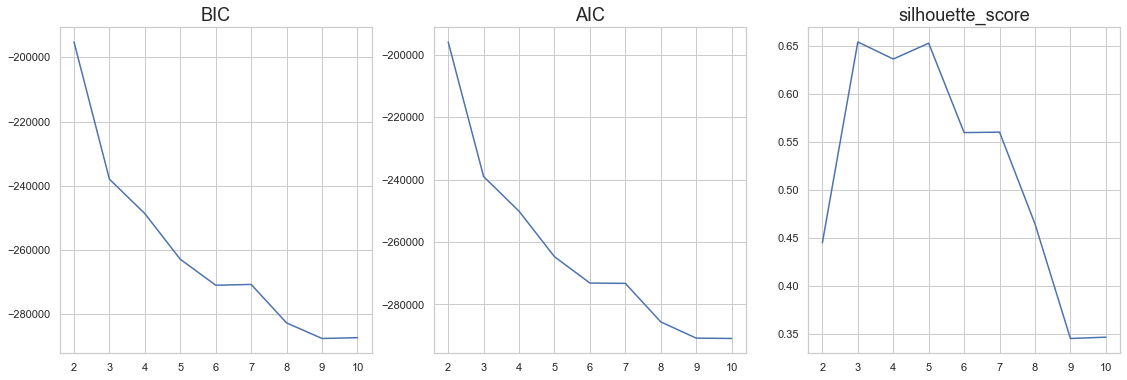

In [37]:
gmm_score_df = pd.DataFrame(
    columns=['n_clusters', 'BIC', 'AIC', 'silhouette_score'])
for i in range(2, 11):
    gm = GaussianMixture(n_components=i, random_state=123)
    gm.fit(features_train2)
    labels = gm.predict(features_train2)

    bic = gm.bic(features_train2)
    aic = gm.aic(features_train2)
    silhouette = silhouette_score(features_train2, labels)


    to_append = pd.DataFrame([[i, bic, aic, silhouette]],
                             columns=['n_clusters', 'BIC', 'AIC', 'silhouette_score'])
    gmm_score_df = pd.concat([gmm_score_df, to_append])

fig, ax = plt.subplots(1, 3, figsize=(19, 6))
ax[0].plot(gmm_score_df.n_clusters, gmm_score_df.BIC)
ax[1].plot(gmm_score_df.n_clusters, gmm_score_df.AIC)
ax[2].plot(gmm_score_df.n_clusters, gmm_score_df.silhouette_score)
ax[0].set_title('BIC', fontsize=18)
ax[1].set_title('AIC', fontsize=18)
ax[2].set_title('silhouette_score', fontsize=18)

In [38]:
gmm_model = GaussianMixture(n_components=3, random_state=123, n_init=10)
label_gmm = gmm_model.fit_predict(features_train2)

In [39]:
pd.Series(label_gmm).value_counts()

1    1540
2    1397
0    1193
dtype: int64

/Users/minhkhoa/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


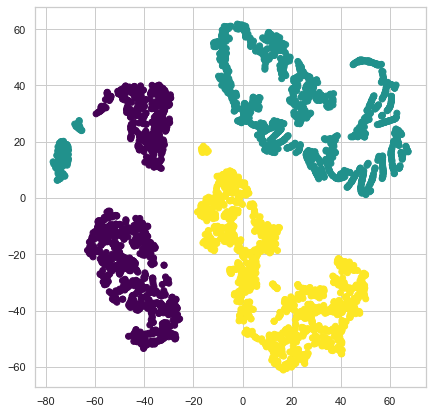

In [40]:
x_plot3 = TSNE(n_components=2, learning_rate='auto', random_state=20).fit_transform(features_train2)
plt.figure(figsize=(7,7))
plt.scatter(x_plot3[:,0], x_plot3[:,1],c=label_gmm, cmap='viridis')

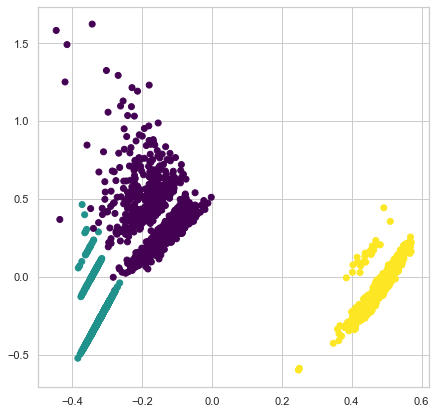

In [41]:
x_plot3 = PCA(n_components=2, random_state=20).fit_transform(features_train2)
plt.figure(figsize=(7,7))
plt.scatter(x_plot3[:,0], x_plot3[:,1],c=label_gmm, cmap='viridis')

In [42]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class ComplexRadar():
    def __init__(self, fig, variables, ranges,n_ordinate_levels=5):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i))
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles,
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle
             in zip(text, angles)]

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)

        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2))
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0, 1, title, transform = self.ax.transAxes, *args, **kw)

In [43]:
variables = x2.columns[:-1]
ranges = [(0, 10), (0,3), (0, 3),
          (0, 3), (0, 1), (0, 500),
          (0, 250), (0,6000)]

In [44]:
x_train2.fillna(0,inplace=True)
x_test2.fillna(0,inplace=True)

In [45]:
def plot_clusters(cluster):
    fig = plt.figure(figsize=(7, 7))
    dt = x_train2[label_gmm==cluster]
    radar = ComplexRadar(fig, variables, ranges)
    radar.plot(dt.mean())
    radar.fill(dt.mean(), alpha=0.2)
    radar.title(f"Cluster {cluster}\n{dt.shape[0]} Customers", c='r', fontsize=20)
    plt.show()

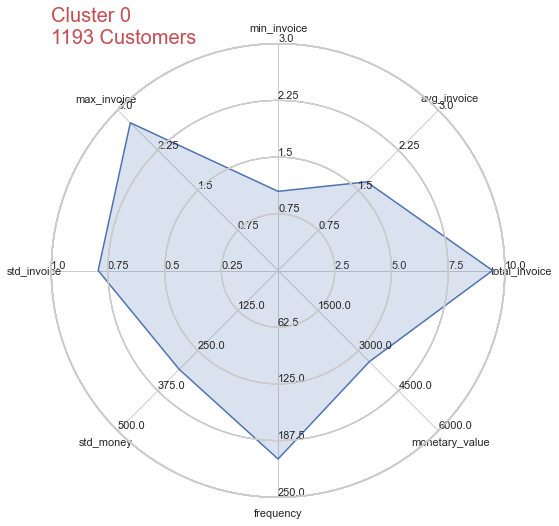

In [46]:
plot_clusters(0)

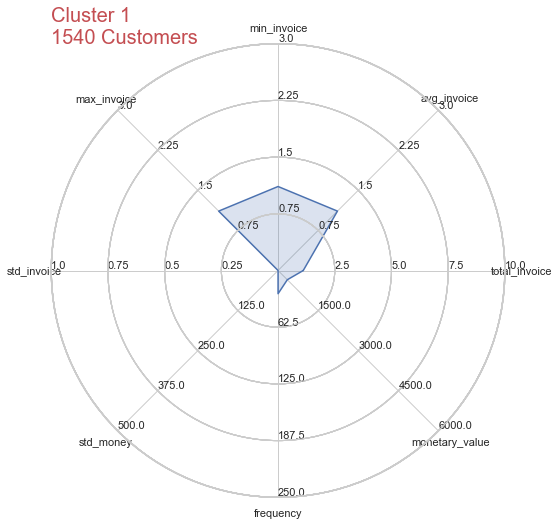

In [47]:
plot_clusters(1)

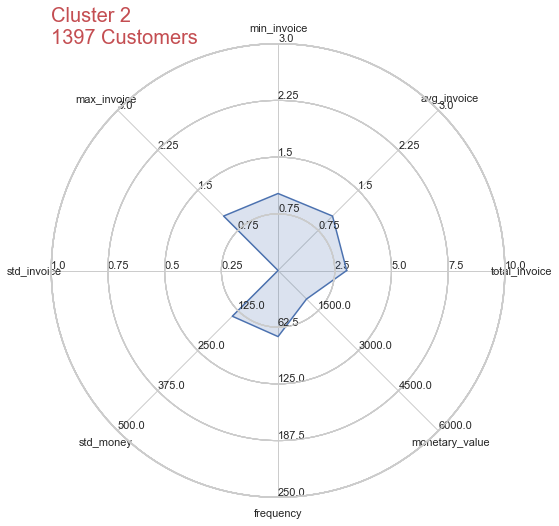

In [48]:
plot_clusters(2)

# Test set (2011)

In [49]:
label_test = gmm_model.predict(feature_test2)

In [50]:
pd.Series(label_test).value_counts()

1    1620
2    1443
0    1072
dtype: int64

In [51]:
def plot_clusters2(cluster):
    fig = plt.figure(figsize=(7, 7))
    dt = x_test2[label_test==cluster]
    radar = ComplexRadar(fig, variables, ranges)
    radar.plot(dt.mean())
    radar.fill(dt.mean(), alpha=0.2)
    radar.title(f"Cluster {cluster}\n{dt.shape[0]} Customers", c='r', fontsize=20)
    plt.show()

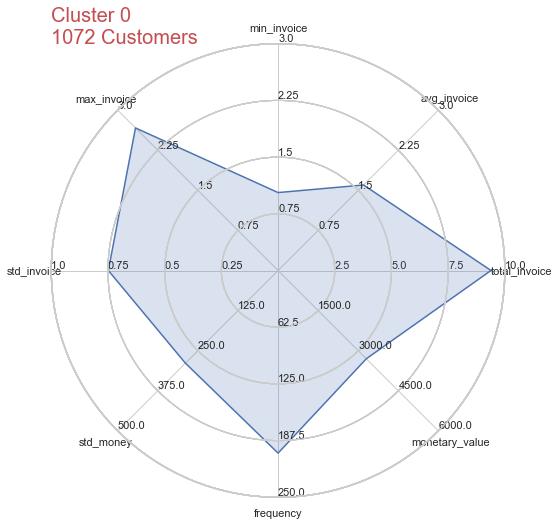

In [52]:
plot_clusters2(0)

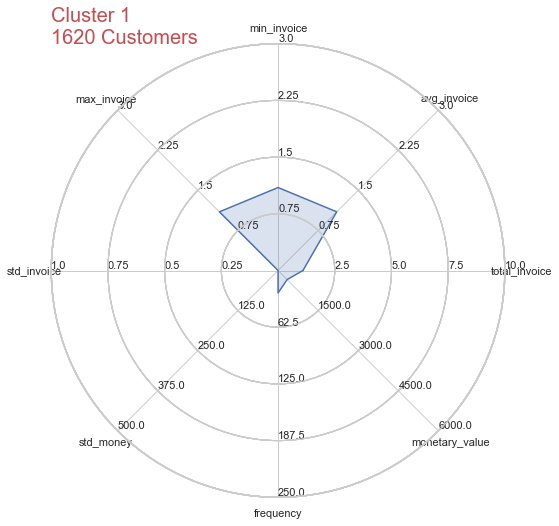

In [53]:
plot_clusters2(1)

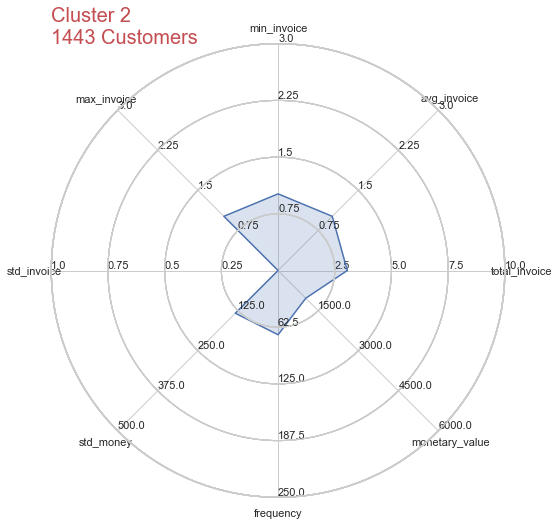

In [54]:
plot_clusters2(2)

/Users/minhkhoa/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


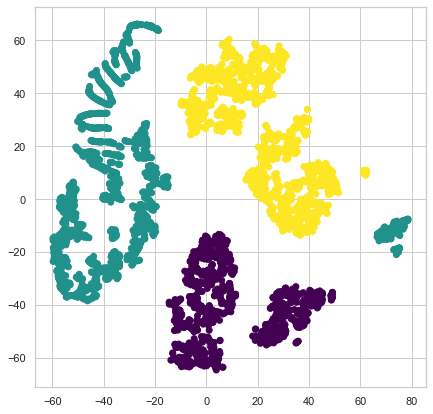

In [55]:
x_plot3 = TSNE(n_components=2, learning_rate='auto', random_state=20).fit_transform(feature_test2)
plt.figure(figsize=(7,7))
plt.scatter(x_plot3[:,0], x_plot3[:,1],c=label_test, cmap='viridis')

In [56]:
new_df_train = x_train2.copy()
new_df_train.index = pd.Series(x_train2.index).str.split('_', n=1, expand=True)[0]
new_df_train['label_2010'] = label_gmm

new_df_test = x_test2.copy()
new_df_test.index = pd.Series(x_test2.index).str.split('_', n=1, expand=True)[0]
new_df_test['label_2011'] = label_test

In [57]:
comparison = pd.merge(new_df_train, new_df_test, left_index=True, right_index=True,how='outer')[['label_2010', 'label_2011']]
comparison

,label_2010,label_2011
0,,
12346,2.0,NaN
12347,2.0,2.0
12348,2.0,2.0
12349,2.0,1.0
12350,NaN,1.0
...,...,...
18283,0.0,0.0
18284,1.0,NaN
18285,1.0,NaN
